In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
import pickle
import re
import inflect
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [21]:
# --- 1. Load datasets ---
building_df = pd.read_csv('/work/building_dataset.csv')
world_df = pd.read_csv('/work/world_real_estate_data(147k).csv')
fleat_df = pd.read_csv('/work/flats - flats.csv')


In [24]:
# --- 2. Standardize and rename columns ---
building_df = building_df.rename(columns={
    'Height': 'height', 'Location': 'location', 'Area': 'area', 'Age': 'age', 'Num_Floors': 'floors'
})

world_df = world_df.rename(columns={
    'building_total_floors': 'floors', 'location': 'location', 'country': 'country',
    'apartment_total_area': 'area', 'building_construction_year': 'age',
    'apartment_bedrooms': 'bedrooms', 'apartment_bathrooms': 'bathrooms', 'price_in_USD': 'price'
})

fleat_df = fleat_df.rename(columns={
    'floorNum': 'floors', 'address': 'location', 'area': 'area', 'bedRoom': 'bedrooms',
    'bathroom': 'bathrooms', 'agePossession': 'age', 'price': 'price'
})

In [27]:
# --- 3. Combine location and country for world_df ---
if 'country' in world_df.columns:
    world_df['location'] = world_df['location'].astype(str) + ', ' + world_df['country'].astype(str)

# --- 4. Extract floor numbers from strings ---
def extract_floor_number(value):
    if isinstance(value, str):
        match = re.search(r'(\d+)', value)
        return int(match.group(1)) if match else np.nan
    return value

building_df['floors'] = building_df['floors'].apply(extract_floor_number)
world_df['floors'] = world_df['floors'].apply(extract_floor_number)
fleat_df['floors'] = fleat_df['floors'].apply(extract_floor_number)

In [30]:
# --- 5. Extract numeric area from strings ---
def extract_numeric_area(value):
    if isinstance(value, str):
        value = re.sub(r'[^0-9.]', '', value.replace(',', ''))
        try:
            return float(value)
        except:
            return np.nan
    return value

fleat_df['area'] = fleat_df['area'].apply(extract_numeric_area)

In [33]:
# --- 6. Select and combine common columns ---
cols = ['location', 'floors', 'area', 'bedrooms', 'bathrooms', 'age', 'price']
world_df = world_df[cols].dropna(subset=['price'])
fleat_df = fleat_df[cols].dropna(subset=['price'])
combined_df = pd.concat([world_df, fleat_df], ignore_index=True)

In [36]:
# --- 7. Merge building info ---
building_df['location'] = building_df['location'].astype(str)
combined_df['location'] = combined_df['location'].astype(str)

if 'location' in building_df.columns:
    building_info = building_df[['location', 'floors', 'height']]
    combined_df = combined_df.merge(building_info, on='location', how='left', suffixes=('', '_building'))
    combined_df['floors'] = combined_df['floors_building'].combine_first(combined_df['floors'])
    combined_df['height'] = combined_df['height'].fillna(0)
    combined_df.drop(columns=['floors_building'], inplace=True)


In [39]:
# --- 8. Clean and fill missing values ---
for col in ['floors', 'area', 'bedrooms', 'bathrooms', 'age']:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
    if combined_df[col].notnull().sum() > 0:
        median_val = combined_df[col].median()
    else:
        print(f"⚠️ Column '{col}' has all NaNs. Filling with 0.")
        median_val = 0
    combined_df[col] = combined_df[col].fillna(median_val)


⚠️ Column 'area' has all NaNs. Filling with 0.


In [45]:
combined_df['price'] = pd.to_numeric(combined_df['price'], errors='coerce')
combined_df = combined_df.dropna(subset=['price'])


In [54]:
# --- 9. Encode location ---
combined_df.loc[:, 'price'] = pd.to_numeric(combined_df['price'], errors='coerce')
combined_df = combined_df.dropna(subset=['price'])

location_means = combined_df.groupby('location', dropna=False)['price'].mean()
combined_df.loc[:, 'location_encoded'] = combined_df['location'].map(location_means)
combined_df.loc[:, 'location_encoded'] = combined_df['location_encoded'].fillna(location_means.mean())


In [57]:
# --- 10. Prepare features and scale ---
features = ['floors', 'area', 'bedrooms', 'bathrooms', 'age', 'location_encoded']
X = combined_df[features].replace([np.inf, -np.inf], np.nan).fillna(combined_df[features].median())
y = combined_df['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [60]:
# --- 11. Split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [69]:
# --- 12. XGBoost training ---
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_dist = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
search = RandomizedSearchCV(model, param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
search.fit(X_train, y_train)
best_model = search.best_estimator_

In [72]:
# --- 13. Evaluate ---
y_pred = best_model.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))


RMSE: 599450.7915547215
R2: 0.44993824110737535


In [75]:
# --- 14. Forecast ---
growth_rate = 0.05
base_price = best_model.predict(X_test[:1])[0]
years = list(range(2026, 2036))
future_prices = [base_price * (1 + growth_rate) ** (year - 2025) for year in years]

In [78]:
# --- 15. Prices to words ---
p = inflect.engine()
for year, price in zip(years, future_prices):
    print(f"{year}: {p.number_to_words(int(price))} dollars")


2026: eight hundred and fifty-eight thousand, six hundred and fifty-seven dollars
2027: nine hundred and one thousand, five hundred and ninety dollars
2028: nine hundred and forty-six thousand, six hundred and sixty-nine dollars
2029: nine hundred and ninety-four thousand and three dollars
2030: one million, forty-three thousand, seven hundred and three dollars
2031: one million, ninety-five thousand, eight hundred and eighty-eight dollars
2032: one million, one hundred and fifty thousand, six hundred and eighty-three dollars
2033: one million, two hundred and eight thousand, two hundred and seventeen dollars
2034: one million, two hundred and sixty-eight thousand, six hundred and twenty-eight dollars
2035: one million, three hundred and thirty-two thousand and fifty-nine dollars


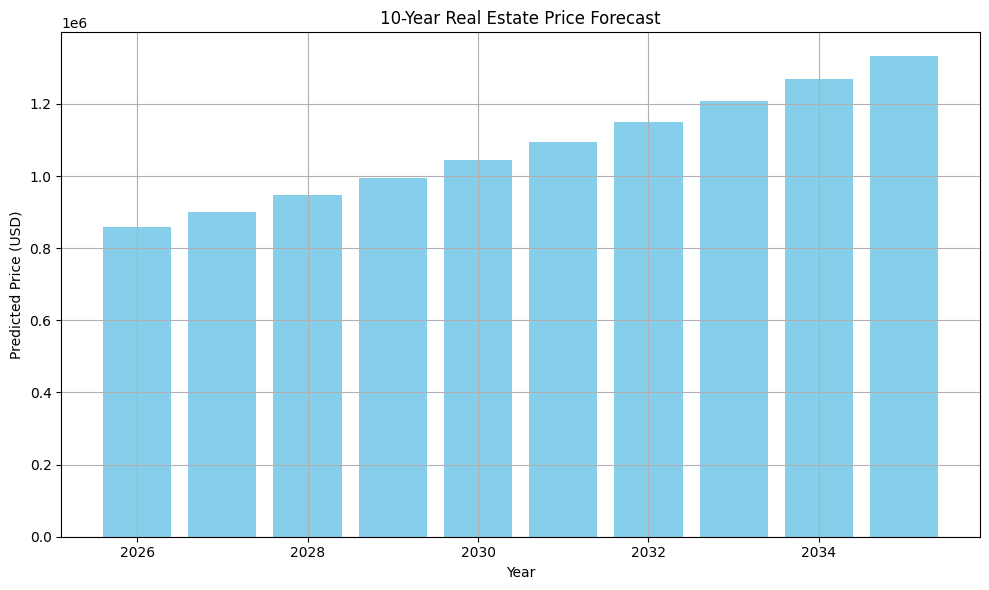

In [81]:
# --- 16. Bar chart ---
plt.figure(figsize=(10, 6))
plt.bar(years, future_prices, color='skyblue')
plt.xlabel("Year")
plt.ylabel("Predicted Price (USD)")
plt.title("10-Year Real Estate Price Forecast")
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
# --- 17. Save ---
joblib.dump(best_model, 'xgboost_real_estate_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
with open('location_encoding.pkl', 'wb') as f:
    pickle.dump(location_means.to_dict(), f)

print("✅ Model, scaler, and encodings saved successfully.")

✅ Model, scaler, and encodings saved successfully.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=00b2d98d-bd56-4a3a-9fdc-9871d936bf03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>